<a href="https://colab.research.google.com/github/bth0114/AIFFEL_DLThon_DKTC_online13/blob/main/notebooks/taehoon/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install konlpy
!pip install wandb

## 모듈 불러오기 및 파일 경로 지정

In [25]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger
wandb.login()

True

In [26]:
#  GitHub에서 CSV 파일 다운로드
!mkdir -p data/raw_csv
!wget https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv -O data/raw_csv/merged_train.csv

#  현재 디렉토리 기준 경로 설정
current_dir = os.getcwd()
csv_dir = os.path.join(current_dir, 'data', 'raw_csv')
train_csv_path = os.path.join(csv_dir, 'merged_train.csv')

#  데이터 로드 테스트
df = pd.read_csv(train_csv_path)
print("샘플 5개:")
print(df.head())

--2025-05-02 06:05:46--  https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2547026 (2.4M) [application/octet-stream]
Saving to: ‘data/raw_csv/merged_train.csv’

data/raw_csv/merged 100%[===================>]   2.43M  --.-KB/s    in 0.05s   

2025-05-02 06:05:46 (51.9 MB/s) - ‘data/raw_csv/merged_train.csv’ saved [2547026/2547026]

샘플 5개:
    idx        class                                       conversation
0  1951  직장 내 괴롭힘 대화  팀장님 이거 언제까지 마무리 하면 될까요?\n무리하지 말고 넉넉하게 주말까지 다 작...
1  4756        일반 대화  내일 날씨 어떻대?\n비 온다던데. 우산 챙겨가야 할 것 같아.\n에이, 야외 활동...
2  1234    기타 괴롭힘 대화  야 쟤 좀 봐.\n 꼴에 유행하는 옷 입었네 \n 호박에 줄 긋는다고 수박되나 \n...
3  4767        일반 대화  오늘 수업 내용 이해했어?\

## 데이터 전처리
- 구두점 제거
- 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화
- 최대 길이를 기준으로 패딩

In [27]:
INPUT_MAX_LENGTH = 350  # 입력 시퀀스 최대 길이
NUM_WORDS = 7000 # 토큰화에 사용할 단어 갯수
EMBEDDING_DIM = 64  # 임베딩 차원

In [28]:
df = pd.read_csv(train_csv_path)
ordered_columns = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'] # kaggle에 명시된 순서로 재배치

conversations = df['conversation'].to_list() # input
labels = pd.get_dummies(df['class'])
labels = labels[ordered_columns].to_numpy() # target

In [29]:
# 훈련셋,검증셋 분리
X_train_raw, X_val_raw, y_train, y_val = train_test_split(conversations, labels, test_size=0.2, stratify=labels, random_state=42)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#학습 데이터 경로
train_paths = {
    "merged_train": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv",
    "aug_plus": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_plus_train.csv",
    "aug_synonym": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_synonym_train_only.csv",
    "eda_only": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/eda_only.csv",
    "final_allclass": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/final_train_allclass_eda.csv"
}

# 제출용 test 데이터 경로
test_url = "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/test.csv"

# 1. 데이터 불러오기
df_syn = pd.read_csv(train_paths["aug_synonym"])
df_eda = pd.read_csv(train_paths["eda_only"])

# 2. 라벨 인코딩
label_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
le = LabelEncoder()
le.fit(label_names)

y_train_int = np.argmax(y_train, axis=1)  # 기존 y_train이 one-hot일 경우

# 증강 데이터 라벨 인코딩
X_syn = df_syn['conversation'].tolist()
y_syn = le.transform(df_syn['class'])

X_eda = df_eda['conversation'].tolist()
y_eda = le.transform(df_eda['class'])

# 조합 생성
X1 = X_train_raw
y1 = y_train_int

X2 = X_train_raw + X_syn
y2 = np.concatenate([y_train_int, y_syn])

X3 = X_train_raw + X_eda
y3 = np.concatenate([y_train_int, y_eda])

X4 = X_train_raw + X_syn + X_eda
y4 = np.concatenate([y_train_int, y_syn, y_eda])

# 예시 확인
print(f"샘플 수\nX1: {len(X1)}, X2: {len(X2)}, X3: {len(X3)}, X4: {len(X4)}")

샘플 수
X1: 3709, X2: 11714, X3: 8346, X4: 16351


In [31]:

!pip install datasets
from datasets import Dataset
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# 1. 모델 설정
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 라벨 인코더
le = LabelEncoder()

# 3. 학습 데이터 전처리
def preprocess_train(df):
    df.columns = df.columns.str.strip().str.lower()
    df["label"] = le.fit_transform(df["class"])
    return df.rename(columns={"conversation": "text"})

# 4. 테스트 데이터 전처리 (라벨 없음)
def preprocess_test(df):
    df.columns = df.columns.str.strip().str.lower()
    return df  # 'text' 컬럼 유지

# 5. 토크나이즈 함수
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [56]:
def preprocessing(texts, tokenizer, padded_max_len):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=padded_max_len,
        return_tensors='tf'
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }


from tensorflow.keras.utils import to_categorical

X1_enc = preprocessing(X1, tokenizer, padded_max_len=128)
X2_enc = preprocessing(X2, tokenizer, padded_max_len=128)
X3_enc = preprocessing(X3, tokenizer, padded_max_len=128)
X4_enc = preprocessing(X4, tokenizer, padded_max_len=128)




y1_cat = to_categorical(y1, num_classes=5)
y2_cat = to_categorical(y2, num_classes=5)
y3_cat = to_categorical(y3, num_classes=5)
y4_cat = to_categorical(y4, num_classes=5)

#  검증셋 전처리 추가
X_val_enc = preprocessing(X_val_raw, tokenizer, padded_max_len=128)

#  검증 라벨도 one-hot 인코딩
y_val_cat = to_categorical(y_val, num_classes=5)

## 모델 훈련
- KcELECTRA 모델 사용
- 각 데이터셋별로 모델을 학습
- F1score를 기준으로 조기종료 수행
- 데이터 셋이 적어 여러번 반복 훈련하여 평균을 내면 더욱 정확한 베이스 모델을 구축할 수 있지만 시간과 한정된 자원 상 한 번의 학습만 진행
- 실험결과는 W&B에 기록

In [42]:
!pip install datasets
from datasets import Dataset
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [43]:
from transformers import TFElectraModel, ElectraConfig, AutoTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
from wandb.integration.keras import WandbCallback
from sklearn.metrics import classification_report

# 1. 모델 정의
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = ElectraConfig.from_pretrained(MODEL_NAME)
electra_backbone = TFElectraModel.from_pretrained(MODEL_NAME, config=config)

def build_electra_model():
    input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    sequence_output = Lambda(
        lambda x: electra_backbone(x)[0],
        output_shape=(128, 768)
    )({
        'input_ids': input_ids,
        'attention_mask': attention_mask
    })

    cls_output = Lambda(lambda x: x[:, 0, :], output_shape=(768,))(sequence_output)
    x = Dropout(0.3)(cls_output)
    output = Dense(5, activation='softmax')(x)

    return Model(inputs=[input_ids, attention_mask], outputs=output)

model = build_electra_model()
model.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ attention_mask[0… │
│                     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 768)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │      3,845 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1MacroScore(Metric):
    def __init__(self, name="f1", **kwargs):
        super(F1MacroScore, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", shape=(5,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(name="fp", shape=(5,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(name="fn", shape=(5,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)

        for i in range(5):
            true_mask = tf.cast(tf.equal(y_true, i), tf.float32)
            pred_mask = tf.cast(tf.equal(y_pred, i), tf.float32)

            tp_i = tf.reduce_sum(true_mask * pred_mask)
            fp_i = tf.reduce_sum((1 - true_mask) * pred_mask)
            fn_i = tf.reduce_sum(true_mask * (1 - pred_mask))

            self.tp.assign(tf.tensor_scatter_nd_add(self.tp, [[i]], [tp_i]))
            self.fp.assign(tf.tensor_scatter_nd_add(self.fp, [[i]], [fp_i]))
            self.fn.assign(tf.tensor_scatter_nd_add(self.fn, [[i]], [fn_i]))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        return tf.reduce_mean(f1)

    def reset_states(self):
        for var in self.variables:
            var.assign(tf.zeros_like(var))



In [49]:
# F1MacroScore는 이미 정의한 상태라고 가정
from tensorflow.keras.callbacks import EarlyStopping

# 1. 각 모델에 직접 구현한 F1Score 할당
model1 = build_electra_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy', F1MacroScore(name='f1')])

model2 = build_electra_model()
model2.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy', F1MacroScore(name='f1')])

model3 = build_electra_model()
model3.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy', F1MacroScore(name='f1')])

model4 = build_electra_model()
model4.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy', F1MacroScore(name='f1')])

# 2. 공통 EarlyStopping (val_f1 기준)
early_stop_f1 = EarlyStopping(
    monitor='val_f1',
    patience=2,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# 3. 모델 학습 시작
print("▶ 모델 1: 원본")
history1 = model1.fit(X1_enc, y1_cat, validation_split=0.1, epochs=10, batch_size=32,
                      callbacks=[early_stop_f1], verbose=1)

print("\n▶ 모델 2: 원본 + synonym")
history2 = model2.fit(X2_enc, y2_cat, validation_split=0.1, epochs=10, batch_size=32,
                      callbacks=[early_stop_f1], verbose=1)

print("\n▶ 모델 3: 원본 + EDA")
history3 = model3.fit(X3_enc, y3_cat, validation_split=0.1, epochs=10, batch_size=32,
                      callbacks=[early_stop_f1], verbose=1)

print("\n▶ 모델 4: 원본 + synonym + EDA")
history4 = model4.fit(X4_enc, y4_cat, validation_split=0.1, epochs=10, batch_size=32,
                      callbacks=[early_stop_f1], verbose=1)


▶ 모델 1: 원본
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - accuracy: 0.2405 - f1: 0.2427 - loss: 1.7006 - val_accuracy: 0.3585 - val_f1: 0.2832 - val_loss: 1.4496
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - accuracy: 0.3082 - f1: 0.3183 - loss: 1.5142 - val_accuracy: 0.3288 - val_f1: 0.2901 - val_loss: 1.4089
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - accuracy: 0.3528 - f1: 0.3610 - loss: 1.4458 - val_accuracy: 0.4016 - val_f1: 0.3822 - val_loss: 1.3728
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.3649 - f1: 0.3696 - loss: 1.3916 - val_accuracy: 0.3585 - val_f1: 0.3155 - val_loss: 1.3378
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.3876 - f1: 0.3936 - loss: 1.3396 - val_accuracy: 0.4528 - val_f1: 0.4255 - val_loss: 1.2926
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.4021 - f1: 0.4030 - loss: 1.3223 - val_accuracy: 0.4286 - val_f1: 0.4094 - val_loss: 1.2858
Epoch 7/10
105/105 ━━━━

In [1]:
from wandb.integration.keras import WandbCallback
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  공통 함수 정의
def log_model_to_wandb(model, run_name, notes, X_train, y_train, X_val, y_val, ordered_columns):
    import wandb
    from sklearn.metrics import classification_report
    from wandb.keras import WandbCallback  # 여전히 일부 버전에서 잘 작동함

    run = wandb.init(
    entity="jiwoong-team",
    project="DLThon-DKTC",
    name=run_name,
    notes=notes,
    config=dict(
        architecture="KcELECTRA",
        input_length=128,
        epochs=10,
        batch_size=32
    ),
    reinit=True,
    settings=wandb.Settings(_disable_stats=True)
    )


    #  예측 결과 평가
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)

    #  classification report 테이블 생성
    report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
    columns = ["class", "precision", "recall", "f1-score", "support"]
    data = []
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            row = [label] + [metrics.get(col, None) for col in columns[1:]]
            data.append(row)

    table = wandb.Table(columns=columns, data=data)

    wandb.log({
    "macro_f1": float(report["macro avg"]["f1-score"]),
    "accuracy": float(report["accuracy"]),
    "threat_f1": float(report["협박 대화"]["f1-score"]),
    "extortion_f1": float(report["갈취 대화"]["f1-score"]),
    "workplace_bullying_f1": float(report["직장 내 괴롭힘 대화"]["f1-score"]),
    "other_bullying_f1": float(report["기타 괴롭힘 대화"]["f1-score"]),
    "general_conversation_f1": float(report["일반 대화"]["f1-score"]),
    })


    run.finish()


In [3]:
# 모델 1: 원본 데이터만
log_model_to_wandb(
    model1,
    run_name="KcELECTRA_original_only",
    notes="원본 데이터만 사용",
    X_train=X1_enc, y_train=y1_cat,
    X_val=X_val_enc, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 2: 원본 + Synonym
log_model_to_wandb(
    model2,
    run_name="KcELECTRA_synonym",
    notes="원본 + Synonym 증강",
    X_train=X2_enc, y_train=y2_cat,
    X_val=X_val_enc, y_val=y_val,
    ordered_columns=ordered_columns
)
# 모델 3: 원본 + EDA
log_model_to_wandb(
    model3,
    run_name="KcELECTRA_eda",
    notes="원본 + EDA 증강",
    X_train=X3_enc, y_train=y3_cat,
    X_val=X_val_enc, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 4: 원본 + Synonym + EDA
log_model_to_wandb(
    model4,
    run_name="KcELECTRA_synonym_eda",
    notes="원본 + Synonym + EDA 증강",
    X_train=X4_enc, y_train=y4_cat,
    X_val=X_val_enc, y_val=y_val,
    ordered_columns=ordered_columns
)


NameError: name 'model1' is not defined

## 결과 분석

In [ ]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print(confusion_matrix(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns))

+ 데이터 EDA 때 예상한 대로 일반대화에 많이 과적합되었으며 직장 내 괴롭힘 대화는 점수가 높음
+ 나머지 세 카테고리에 대해서는 아쉬운 성능

## submission

In [ ]:
test_csv_path = os.path.join(csv_dir, 'test.csv')

df_test = pd.read_csv(test_csv_path)
conversations_test = df_test['text'].to_list()

X_text = preprocessing(conversations_test, tokenizer, INPUT_MAX_LENGTH)

In [ ]:
# 모델 예측 (Softmax를 사용하여 각 클래스에 대한 확률 계산)
predictions = model.predict(X_text)

# 예측 결과를 클래스 인덱스로 변환
predicted_classes = predictions.argmax(axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
# id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': df_test['idx'],
    'class': predicted_classes
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('/content/submission.csv', index=False)

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,0
497,t_497,1
498,t_498,1


## 제출 결과

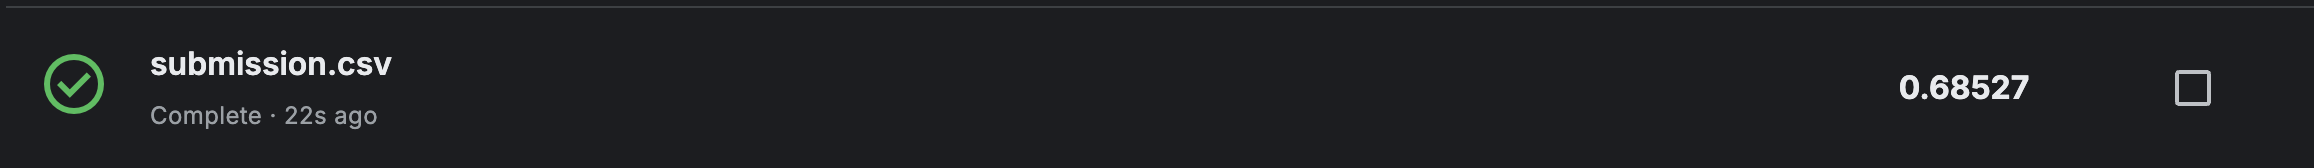